# Single Cell Club 

Date: June 14, 2021

Author: Yuan Hao

## Part I: Basic scRNAseq data analysis 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

## Pancreatic Endocrinogenesis Data

Data from Bastidas-Ponce *et al*. Development. (2019).

Single cell RNAseq experiments were performed using 10X Genomics technology to generate single cell transcriptomic profiles of embryonic pancreatic epithelial cells from Ngn3-Venus fusion (NVF) reporter mouse line sampled on embryonic day 15.5.

Endocrine commitment terminates in four major fates: glucagon-producing **α-cells**, insulin-producing **β-cells**, somatostatin-producing **δ-cells** and ghrelin-producing **ε-cells**.

In [2]:
# Organizing I/O files
work_dir = '/Users/yuanhao/Desktop/scClub/'

in_files = work_dir + 'GSM3852755_E15_5/mm10/' # 10x input directory containing count matrix
out_file = work_dir + 'GSM3852755_E15_5.h5ad' # output file
cc_s_file = work_dir + 'cc.s.genes.txt' # cell cycle genes
cc_g2m_file = work_dir + 'cc.g2m.genes.txt'

In [3]:
# Creating an anndata object from count matrix
adata = sc.read_10x_mtx(in_files, var_names='gene_symbols', cache=True)                   

In [4]:
adata.var_names_make_unique('-') 

In [5]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata

AnnData object with n_obs × n_vars = 11437 × 17931
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [7]:
# Calculate quality control metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p=False, inplace=True)

In [8]:
adata

AnnData object with n_obs × n_vars = 11437 × 17931
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

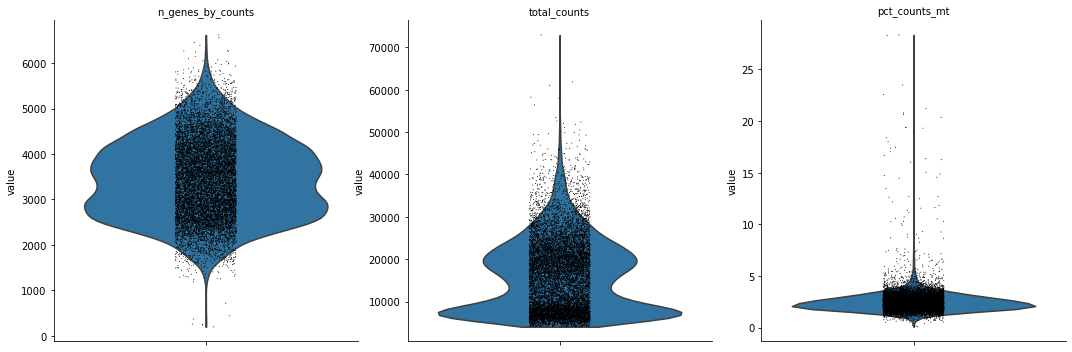

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True)

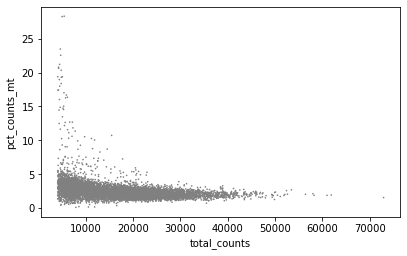

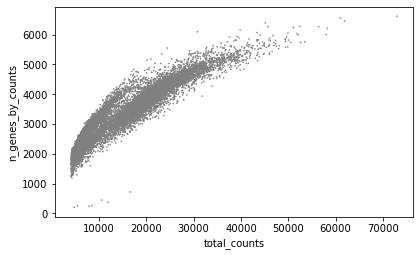

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
# QC filtering 
adata = adata[(adata.obs.n_genes_by_counts > 1000) & (adata.obs.n_genes_by_counts < 6000), :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
# Library size normalization & log transformation 
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [13]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

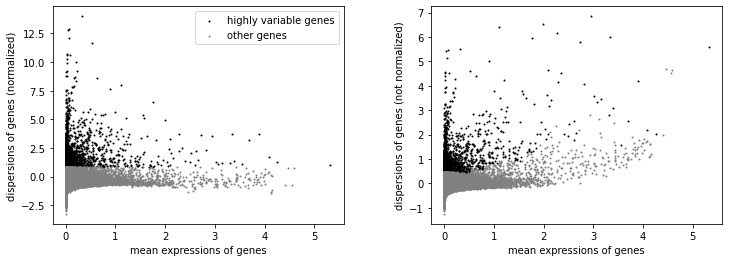

In [14]:
sc.pl.highly_variable_genes(adata)

In [15]:
# Scoring cell cycle genes
s_genes = [x.strip() for x in open(cc_s_file)]
g2m_genes = [x.strip() for x in open(cc_g2m_file)]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [16]:
# Identify highly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [17]:
# Regressing, centering and Scaling
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


In [18]:
# Calculating PCA
sc.tl.pca(adata, svd_solver='arpack')

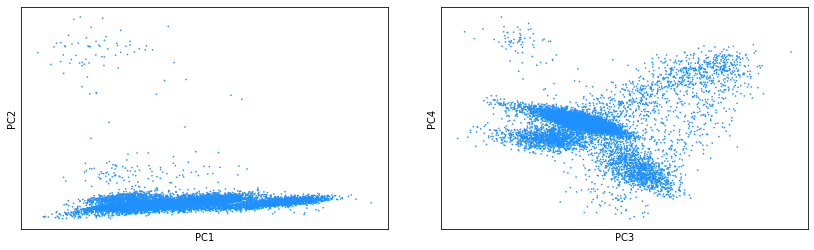

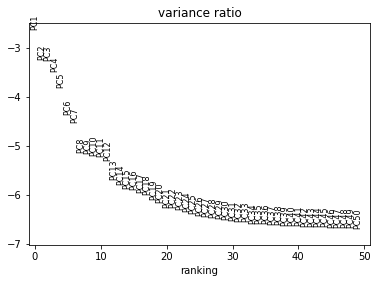

In [19]:
sc.pl.pca(adata, na_color='dodgerblue', components=['1,2', '3,4'])
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

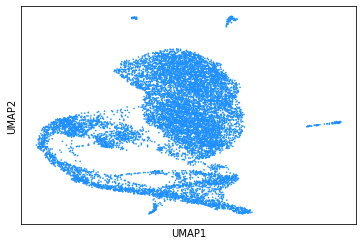

In [20]:
# Computing the neighborhood graph and UMAP 
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, na_color='dodgerblue')

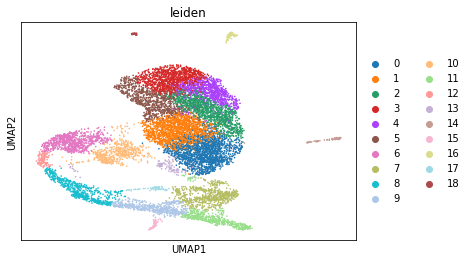

In [21]:
# clustering
sc.tl.leiden(adata) 
sc.pl.umap(adata, color='leiden', na_color='dodgerblue')

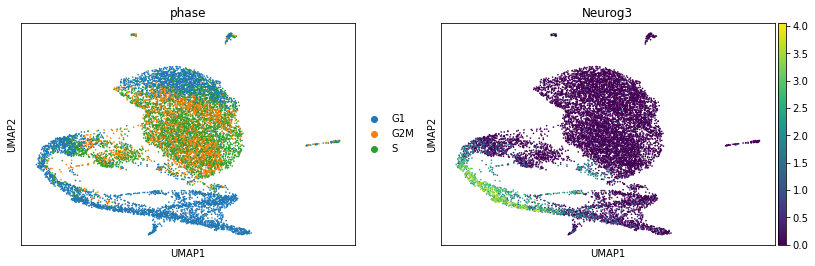

In [22]:
sc.pl.umap(adata, color=['phase','Neurog3'])

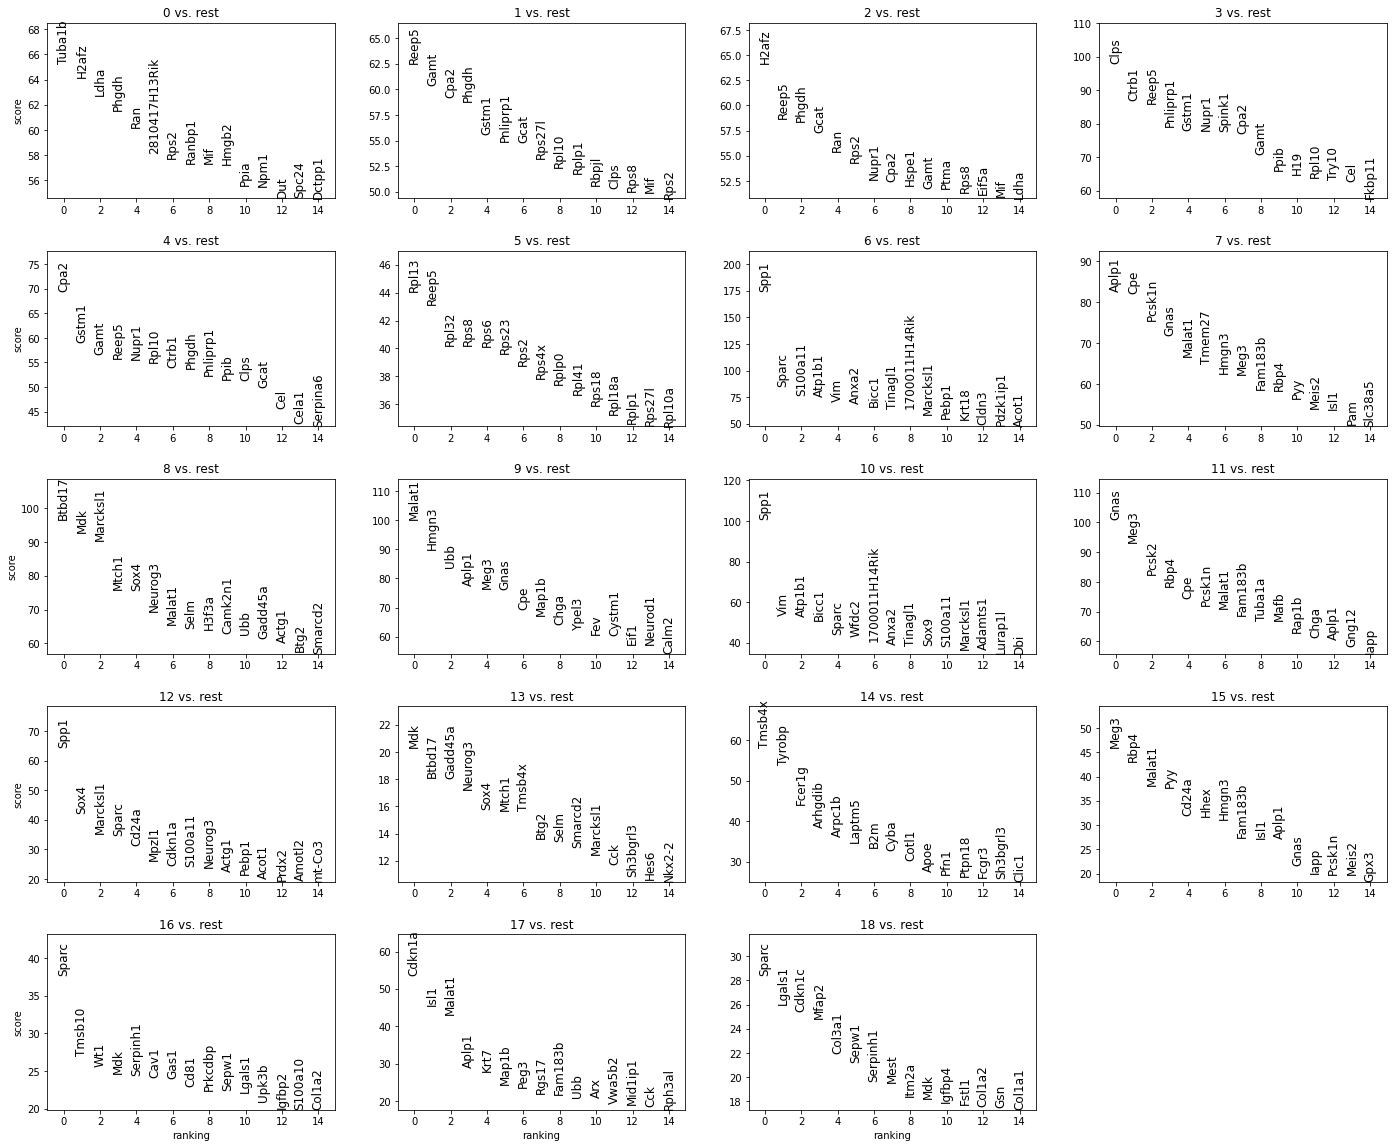

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Tuba1b,Reep5,H2afz,Clps,Cpa2,Rpl13,Spp1,Aplp1,Btbd17,Malat1,Spp1,Gnas,Spp1,Mdk,Tmsb4x,Meg3,Sparc,Cdkn1a,Sparc
1,H2afz,Gamt,Reep5,Ctrb1,Gstm1,Reep5,Sparc,Cpe,Mdk,Hmgn3,Vim,Meg3,Sox4,Btbd17,Tyrobp,Rbp4,Tmsb10,Isl1,Lgals1
2,Ldha,Cpa2,Phgdh,Reep5,Gamt,Rpl32,S100a11,Pcsk1n,Marcksl1,Ubb,Atp1b1,Pcsk2,Marcksl1,Gadd45a,Fcer1g,Malat1,Wt1,Malat1,Cdkn1c
3,Phgdh,Phgdh,Gcat,Pnliprp1,Reep5,Rps8,Atp1b1,Gnas,Mtch1,Aplp1,Bicc1,Rbp4,Sparc,Neurog3,Arhgdib,Pyy,Mdk,Aplp1,Mfap2
4,Ran,Gstm1,Ran,Gstm1,Nupr1,Rps6,Vim,Malat1,Sox4,Meg3,Sparc,Cpe,Cd24a,Sox4,Arpc1b,Cd24a,Serpinh1,Krt7,Col3a1


In [23]:
# Finding marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False, fontsize=12)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

Trying to set attribute `.obs` of view, copying.
... storing 'final_cluster' as categorical
... storing 'final_cluster_fine' as categorical


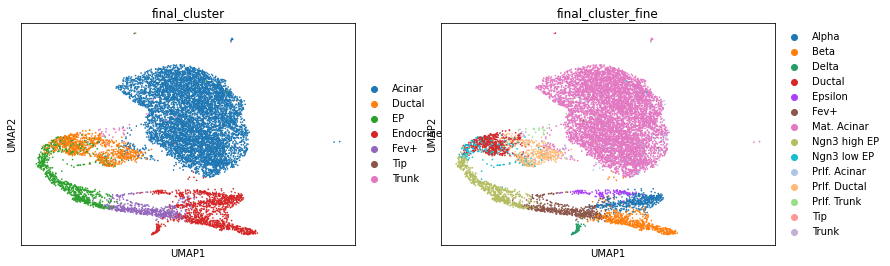

In [24]:
# Import orignal cell annotation 
anno_file = work_dir + 'GSM3852755_E15_5/E15_5_cell_annotation.txt'
anno = pd.read_csv(anno_file, delimiter='\t')
common_obs = adata.obs_names.intersection(anno['barcode'])
anno = anno.loc[anno['barcode'].isin(common_obs)]
adata = adata[adata.obs_names.isin(common_obs)]
adata.obs['final_cluster'] = anno['clusters_fig2_final'].tolist()
adata.obs['final_cluster_fine'] = anno['clusters_fig6_broad_final'].tolist()
sc.pl.umap(adata,color=['final_cluster','final_cluster_fine'])

## Part II: Cell Velocity Estimation

Velocyto (http://velocyto.org/) can be used to calculate unspliced and spliced mRNAs from fastq files of scRNASeq data. Here, given no access to the orignal fastq files, we extracted the un-/spliced information for a subset of embryonic data from public resource. scVelo package is used for cell velocity estimation analysis. 

In [25]:
# Import sliced/unspliced data
spliced=sc.read(work_dir + 'GSM3852755_E15_5/spliced.h5ad')
unspliced=sc.read(work_dir + 'GSM3852755_E15_5/unspliced.h5ad')

common_obs = adata.obs_names.intersection(spliced.obs_names)
common_var = adata.var_names.intersection(spliced.var_names)

adata = adata[adata.obs_names.isin(common_obs), adata.var_names.isin(common_var)]
spliced = spliced[spliced.obs_names.isin(common_obs),spliced.var_names.isin(common_var)]
unspliced = unspliced[unspliced.obs_names.isin(common_obs),unspliced.var_names.isin(common_var)]

adata.layers['spliced']=spliced.X
adata.layers['unspliced'] = unspliced.X

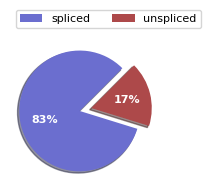

In [26]:
scv.pl.proportions(adata)

In [27]:
# Estimating velocity
scv.pp.moments(adata, n_pcs=30, n_neighbors=30) #  calculate first and second order moments among nearest neighbors
scv.tl.recover_dynamics(adata, n_jobs=8) # estimate transcriptional dynamics of splicing kinetics
scv.tl.velocity(adata, mode='dynamical') # estimate cell velocities
scv.tl.velocity_graph(adata) # estimate cell transition probabilities 

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)



    finished (0:01:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


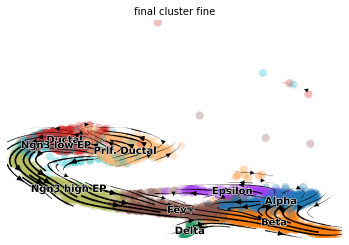

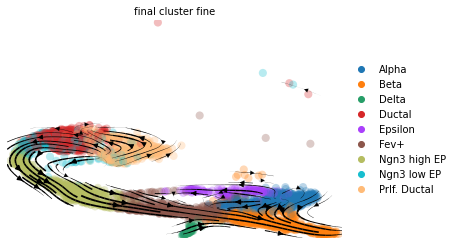

In [28]:
# Embedding velocity on UMAP
scv.pl.velocity_embedding_stream(adata, basis='umap', color='final_cluster_fine')
scv.pl.velocity_embedding_stream(adata, basis='umap', color='final_cluster_fine', legend_loc='right margin')

In [29]:
adata.write(out_file)